In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [2]:
np.random.seed(6898)

## LOAD DATASET

In [3]:
# GENERATE DATA FROM STABLE DISTRI
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

In [4]:
actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 1)
actual_data

array([[-3.88975934e+00, -2.57689691e-01, -7.97460898e-02,
         5.07076654e+00, -1.88625009e+00,  1.07665978e+00,
        -6.47186701e-02, -7.13005622e-01,  1.32610675e+01,
         3.39726650e+00, -1.05425022e+00,  1.14847724e+00,
        -1.66617262e-01, -1.86816172e+00, -1.39097829e+00,
        -7.44844139e-01, -8.05940725e-01, -1.28805593e+00,
        -8.66451792e-01,  1.23163010e+00,  9.85988933e+00,
         1.51581699e+00, -2.06700796e+00, -1.26760674e+00,
         1.51792956e+00, -4.13461914e-01, -4.23998573e-01,
        -5.81133590e-01, -1.28460756e+00, -5.65309433e+00,
        -1.11292582e+00,  1.71870841e+01, -1.64668272e+00,
        -2.45185397e+00, -1.12796567e+00,  4.36524625e-01,
        -1.79445799e+00,  7.80406710e-02,  5.91571005e-01,
         1.33981679e+00,  1.75659962e+00,  9.28647749e-01,
         4.18568025e-01,  9.43488938e-01, -4.41075434e-01,
         2.95789038e-01, -2.87640841e+00,  3.08421739e+00,
         6.20774912e-01, -9.40483382e-01,  5.35135044e-0

In [5]:
# CALCULATE SUMMARY STATS
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

# actual_summary_statistics = alpha_stable_ss(actual_data)
# actual_summary_statistics

In [6]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [7]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.36258691,  0.17534717,  0.95394324, -0.20993959])

In [8]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [9]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200

In [10]:
def prior(theta): 
    log_prior = multivariate_normal.logpdf(theta, cov= 10 * np.identity(num_coeffs))
    return log_prior

def unbiased_log_likelihood(theta):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    diff_mean_s = actual_summary_statistics - sample_mean
    part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) -1/2 * part1
    return u_est_log_likelihood

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [11]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (self.num_coeffs,1))) * (theta - mu)), l)).T[np.triu_indices(self.num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    # Find gradient of LB
                    h_lambda_init = prior(theta_tilde_0) + unbiased_log_likelihood(theta_0) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])
                    
                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + unbiased_log_likelihood(theta_q) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [12]:
# Set hyperparameters
stop = 5000

In [14]:
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [00:58<81:32:32, 58.72s/it]

LB -7.869237545518399


  0%|          | 2/5000 [01:56<80:52:57, 58.26s/it]

LB -8.15177616903751


  0%|          | 3/5000 [02:49<77:18:24, 55.69s/it]

LB -8.228099647742368


  0%|          | 4/5000 [03:44<77:05:18, 55.55s/it]

LB -7.972235214343916


  0%|          | 5/5000 [04:39<76:51:13, 55.39s/it]

LB -7.731434486639671


  0%|          | 6/5000 [05:34<76:38:52, 55.25s/it]

LB -7.727830458291653


  0%|          | 7/5000 [06:28<76:08:45, 54.90s/it]

LB -7.655962718147523


  0%|          | 8/5000 [07:24<76:19:44, 55.04s/it]

LB -7.819200699937514


  0%|          | 9/5000 [08:17<75:33:32, 54.50s/it]

LB -7.519966073783455


  0%|          | 10/5000 [09:09<74:21:49, 53.65s/it]

LB -7.419449720166656


  0%|          | 11/5000 [10:00<73:22:34, 52.95s/it]

LB -7.471324102461291


  0%|          | 12/5000 [10:51<72:22:01, 52.23s/it]

LB -7.234027384117792


  0%|          | 13/5000 [11:41<71:38:31, 51.72s/it]

LB -7.300317690046087


  0%|          | 14/5000 [12:32<71:16:00, 51.46s/it]

LB -7.236928148953948


  0%|          | 15/5000 [13:23<71:03:19, 51.31s/it]

LB -7.110785226833068


  0%|          | 16/5000 [14:17<72:18:26, 52.23s/it]

LB -7.115555248460864


  0%|          | 17/5000 [15:12<73:20:54, 52.99s/it]

LB -6.835798807766282


  0%|          | 18/5000 [16:05<73:15:19, 52.93s/it]

LB -6.726132548427907


  0%|          | 19/5000 [17:02<74:57:53, 54.18s/it]

LB -6.9599225944627525


  0%|          | 20/5000 [17:55<74:27:59, 53.83s/it]

LB -6.9242269586022465


  0%|          | 21/5000 [18:56<77:27:26, 56.00s/it]

LB -6.634776256023392


  0%|          | 22/5000 [19:56<79:11:12, 57.27s/it]

LB -6.771708010609691


  0%|          | 23/5000 [20:51<78:14:37, 56.60s/it]

LB -6.442089435470262


  0%|          | 24/5000 [21:47<78:00:04, 56.43s/it]

LB -6.595941900429846


  0%|          | 25/5000 [22:41<76:49:52, 55.60s/it]

LB -6.524522984452428


  1%|          | 26/5000 [23:38<77:10:55, 55.86s/it]

LB -6.561007772383903


  1%|          | 27/5000 [24:40<79:44:03, 57.72s/it]

LB -6.590573875911075


  1%|          | 28/5000 [25:37<79:21:54, 57.46s/it]

LB -6.445320119029886


  1%|          | 29/5000 [26:36<80:14:59, 58.12s/it]

LB -6.406955897754231


  1%|          | 30/5000 [27:33<79:29:14, 57.58s/it]

LB -6.560373849695461


  1%|          | 31/5000 [28:27<78:20:25, 56.76s/it]

LB -6.513552995620746


  1%|          | 32/5000 [29:24<78:20:32, 56.77s/it]

LB -6.534087695625074


  1%|          | 33/5000 [30:24<79:28:34, 57.60s/it]

LB -6.434804204209372


  1%|          | 34/5000 [31:22<79:33:32, 57.67s/it]

LB -6.471833337324052


  1%|          | 35/5000 [32:16<78:16:47, 56.76s/it]

LB -6.4132094246532345


  1%|          | 36/5000 [33:09<76:28:38, 55.46s/it]

LB -6.4547338095647095


  1%|          | 37/5000 [34:01<75:13:06, 54.56s/it]

LB -6.419277364260583


  1%|          | 38/5000 [34:54<74:44:15, 54.22s/it]

LB -6.2300967116666275


  1%|          | 39/5000 [35:47<73:48:40, 53.56s/it]

LB -6.385242610294658


  1%|          | 40/5000 [36:39<73:16:15, 53.18s/it]

LB -6.356340342599473


  1%|          | 41/5000 [37:31<72:50:33, 52.88s/it]

LB -6.541820185922766


  1%|          | 42/5000 [38:23<72:32:08, 52.67s/it]

LB -6.4117695673823505


  1%|          | 43/5000 [39:15<72:05:48, 52.36s/it]

LB -6.242738564758578


  1%|          | 44/5000 [40:08<72:15:11, 52.48s/it]

LB -6.343327467195402


  1%|          | 45/5000 [40:59<71:44:54, 52.13s/it]

LB -6.232685041428128


  1%|          | 46/5000 [41:50<71:27:32, 51.93s/it]

LB -6.274164307272406


  1%|          | 47/5000 [42:42<71:31:37, 51.99s/it]

LB -6.115601975635047


  1%|          | 48/5000 [43:34<71:28:30, 51.96s/it]

LB -6.318633438417604


  1%|          | 49/5000 [44:26<71:19:15, 51.86s/it]

LB -6.123747406473567


  1%|          | 50/5000 [45:18<71:20:43, 51.89s/it]

LB -6.035991023130687


  1%|          | 51/5000 [46:12<72:17:33, 52.59s/it]

LB -6.194058741771104


  1%|          | 52/5000 [47:07<73:19:03, 53.34s/it]

LB -6.080731608034199


  1%|          | 53/5000 [48:05<75:07:18, 54.67s/it]

LB -6.244048604968152


  1%|          | 54/5000 [49:02<76:14:09, 55.49s/it]

LB -5.985664506581738


  1%|          | 55/5000 [50:00<76:56:48, 56.02s/it]

LB -6.01401619910341


  1%|          | 56/5000 [50:57<77:28:53, 56.42s/it]

LB -6.254385666308411


  1%|          | 57/5000 [51:51<76:16:29, 55.55s/it]

LB -6.084301283195872


  1%|          | 58/5000 [52:46<76:14:16, 55.54s/it]

LB -6.068434283237471


  1%|          | 59/5000 [53:41<75:54:58, 55.31s/it]

LB -5.991745116606288


  1%|          | 60/5000 [54:38<76:31:09, 55.76s/it]

LB -6.120463690894127


  1%|          | 61/5000 [55:32<75:58:49, 55.38s/it]

LB -5.914407877182555


  1%|          | 62/5000 [56:28<76:06:04, 55.48s/it]

LB -6.091014953959212


  1%|▏         | 63/5000 [57:25<76:45:42, 55.97s/it]

LB -6.111463824207376


  1%|▏         | 64/5000 [58:22<77:18:22, 56.38s/it]

LB -6.129858614598336


  1%|▏         | 65/5000 [59:21<78:08:35, 57.00s/it]

LB -6.1195205916823365


  1%|▏         | 66/5000 [1:00:20<78:55:20, 57.58s/it]

LB -6.220210625779771


  1%|▏         | 67/5000 [1:01:18<79:15:18, 57.84s/it]

LB -6.166261734058565


  1%|▏         | 68/5000 [1:02:16<79:15:57, 57.86s/it]

LB -6.155027443964839


  1%|▏         | 69/5000 [1:03:14<79:07:29, 57.77s/it]

LB -6.10096869310687


  1%|▏         | 70/5000 [1:04:13<79:41:46, 58.20s/it]

LB -5.99785653404497


  1%|▏         | 71/5000 [1:05:11<79:32:34, 58.10s/it]

LB -6.142078316811088


  1%|▏         | 72/5000 [1:06:08<79:24:05, 58.00s/it]

LB -5.966480521710593


  1%|▏         | 73/5000 [1:07:05<78:51:08, 57.61s/it]

LB -6.178884935129684


  1%|▏         | 74/5000 [1:08:02<78:25:17, 57.31s/it]

LB -6.106778761839325


  2%|▏         | 75/5000 [1:09:03<79:51:33, 58.37s/it]

LB -6.01600000624152


  2%|▏         | 76/5000 [1:10:03<80:29:35, 58.85s/it]

LB -5.939320035290774


  2%|▏         | 77/5000 [1:11:00<79:43:15, 58.30s/it]

LB -6.029430780913494


  2%|▏         | 78/5000 [1:11:56<79:02:27, 57.81s/it]

LB -6.120408055735168


  2%|▏         | 79/5000 [1:12:59<80:50:55, 59.15s/it]

LB -6.051306917975142


  2%|▏         | 80/5000 [1:13:58<80:51:08, 59.16s/it]

LB -6.03683728459555


  2%|▏         | 81/5000 [1:14:54<79:33:22, 58.22s/it]

LB -6.0158289303808195


  2%|▏         | 82/5000 [1:15:50<78:35:57, 57.54s/it]

LB -6.011584490974514


  2%|▏         | 83/5000 [1:16:45<77:39:50, 56.86s/it]

LB -5.908379527369706


  2%|▏         | 84/5000 [1:17:39<76:40:09, 56.15s/it]

LB -6.0298874618908895


  2%|▏         | 85/5000 [1:18:35<76:22:06, 55.94s/it]

LB -6.2098494290998545


  2%|▏         | 86/5000 [1:19:32<76:58:17, 56.39s/it]

LB -6.076386655868446


  2%|▏         | 87/5000 [1:20:34<78:57:36, 57.86s/it]

LB -5.882495471745781


  2%|▏         | 88/5000 [1:21:31<78:53:37, 57.82s/it]

LB -5.894829354117382


  2%|▏         | 89/5000 [1:22:29<78:48:45, 57.77s/it]

LB -5.985685863328315


  2%|▏         | 90/5000 [1:23:23<77:19:18, 56.69s/it]

LB -6.117467373018332


  2%|▏         | 91/5000 [1:24:17<76:05:01, 55.80s/it]

LB -5.971353942851542


  2%|▏         | 92/5000 [1:25:13<76:01:02, 55.76s/it]

LB -5.907752787834529


  2%|▏         | 93/5000 [1:26:04<74:08:08, 54.39s/it]

LB -6.001395765410925


  2%|▏         | 94/5000 [1:26:54<72:29:24, 53.19s/it]

LB -5.898343067773303


  2%|▏         | 95/5000 [1:27:48<72:41:23, 53.35s/it]

LB -6.038583144694505


  2%|▏         | 96/5000 [1:28:46<74:34:57, 54.75s/it]

LB -6.083651517510532


  2%|▏         | 97/5000 [1:29:41<74:50:14, 54.95s/it]

LB -6.058738786425688


  2%|▏         | 98/5000 [1:30:34<74:05:53, 54.42s/it]

LB -5.982975418308587


  2%|▏         | 99/5000 [1:31:28<73:50:01, 54.23s/it]

LB -5.980904799922544


  2%|▏         | 100/5000 [1:32:19<72:24:53, 53.20s/it]

LB -6.018518724618268


  2%|▏         | 101/5000 [1:33:09<71:01:05, 52.19s/it]

LB Smoothed -6.426610911071617


  2%|▏         | 102/5000 [1:33:58<69:52:42, 51.36s/it]

LB Smoothed -6.403518421525721


  2%|▏         | 103/5000 [1:34:49<69:35:41, 51.16s/it]

LB Smoothed -6.380885822564782


  2%|▏         | 104/5000 [1:35:41<69:46:46, 51.31s/it]

LB Smoothed -6.360369029137213


  2%|▏         | 105/5000 [1:36:31<69:26:32, 51.07s/it]

LB Smoothed -6.343196651951965


  2%|▏         | 106/5000 [1:37:24<70:15:35, 51.68s/it]

LB Smoothed -6.325010623758012


  2%|▏         | 107/5000 [1:38:16<70:04:57, 51.56s/it]

LB Smoothed -6.306503956174704


  2%|▏         | 108/5000 [1:39:09<70:46:02, 52.08s/it]

LB Smoothed -6.287595255029682


  2%|▏         | 109/5000 [1:40:01<70:52:34, 52.17s/it]

LB Smoothed -6.2719770621952495


  2%|▏         | 110/5000 [1:40:59<73:10:13, 53.87s/it]

LB Smoothed -6.257444789545648


  2%|▏         | 111/5000 [1:41:52<72:48:01, 53.61s/it]

LB Smoothed -6.240803625021927


  2%|▏         | 112/5000 [1:42:43<71:33:26, 52.70s/it]

LB Smoothed -6.2263439898523805


  2%|▏         | 113/5000 [1:43:32<70:18:48, 51.80s/it]

LB Smoothed -6.211807072836003


  2%|▏         | 114/5000 [1:44:23<69:53:20, 51.49s/it]

LB Smoothed -6.1983309930073975


  2%|▏         | 115/5000 [1:45:32<76:54:15, 56.67s/it]

LB Smoothed -6.185845916705006


  2%|▏         | 116/5000 [1:46:33<78:33:32, 57.91s/it]

LB Smoothed -6.174197776062808


  2%|▏         | 117/5000 [1:47:31<78:45:53, 58.07s/it]

LB Smoothed -6.16509129870587


  2%|▏         | 118/5000 [1:48:42<84:01:03, 61.95s/it]

LB Smoothed -6.15664209807928


  2%|▏         | 119/5000 [1:49:57<89:15:27, 65.83s/it]

LB Smoothed -6.14492609222691


  2%|▏         | 120/5000 [1:51:08<91:09:44, 67.25s/it]

LB Smoothed -6.133805691536626


  2%|▏         | 121/5000 [1:52:26<95:37:04, 70.55s/it]

LB Smoothed -6.12710820553406


  2%|▏         | 122/5000 [1:53:45<99:03:39, 73.11s/it]

LB Smoothed -6.118332285490341


  2%|▏         | 123/5000 [1:54:59<99:26:14, 73.40s/it]

LB Smoothed -6.113341554151695


  2%|▏         | 124/5000 [1:56:05<96:25:46, 71.20s/it]

LB Smoothed -6.105763027929305


  2%|▎         | 125/5000 [1:57:06<92:06:14, 68.02s/it]

LB Smoothed -6.100488341713697


  3%|▎         | 126/5000 [1:58:06<89:05:37, 65.81s/it]

LB Smoothed -6.093334254361612


  3%|▎         | 127/5000 [1:59:01<84:40:23, 62.55s/it]

LB Smoothed -6.084855191870549


  3%|▎         | 128/5000 [1:59:55<81:13:39, 60.02s/it]

LB Smoothed -6.080122296483394


  3%|▎         | 129/5000 [2:00:50<79:11:48, 58.53s/it]

LB Smoothed -6.074795215536423


  3%|▎         | 130/5000 [2:01:48<78:50:19, 58.28s/it]

LB Smoothed -6.0668644575148125


In [ ]:
max(LB_estimate)

-5.866374173935086

In [ ]:
best_lambda

array([array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
       array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
              -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

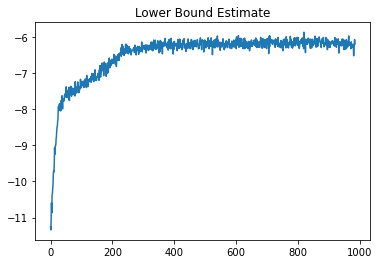

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

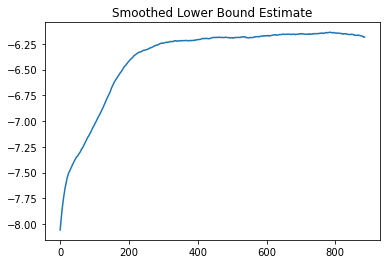

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
np.savetxt('vb_lb.txt', LB_estimate)

In [ ]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.35845714,  0.21826083,  0.81628629, -0.1769098 ])

Text(0.5, 1.0, 'Posterior density of alpha')

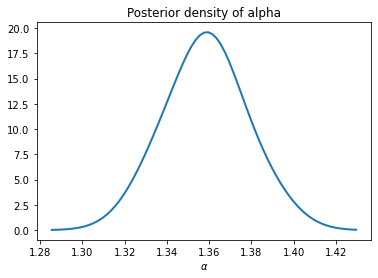

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

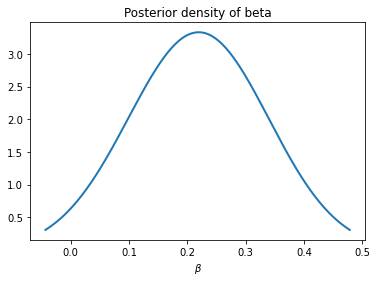

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

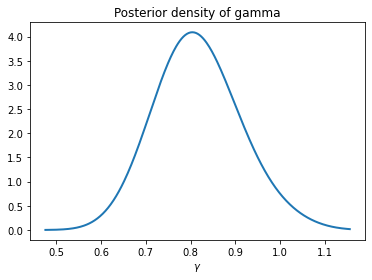

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

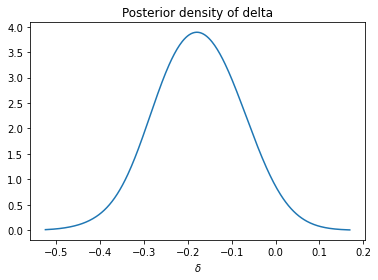

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

	# ------------------- initialize MCMC

	w_size = num_coeffs  # num of weights and bias

	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
	pos_w_tilde = np.ones((samples, w_size))

	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
	gamma = np.exp(w_tilde[2])
	delta = w_tilde[3]
	w = np.array([alpha, beta, gamma, delta])
	
	# --------------------- 

	prior_current = prior(w_tilde)  # takes care of the gradients

	likelihood_current = unbiased_log_likelihood(w) 

	naccept = 0
		
	for i in range(samples - 1):
		if i < 2000:
			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
		else:
			if i % 500 == 0:
				Sign = np.cov(pos_w_tilde[0:i, :].T)
			u_proposal = random.uniform(0, 1)
			if u_proposal < 0.05:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
			else:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
		gamma_prop = np.exp(w_proposal_tilde[2])
		delta_prop = w_proposal_tilde[3]
		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
		likelihood_proposal = unbiased_log_likelihood(w_proposal)

		diff_prior = prior_proposal - prior_current

		diff_likelihood = likelihood_proposal - likelihood_current

		try:
			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

		except OverflowError as e:
			mh_prob = 1


		u = random.uniform(0, 1)

		if u < mh_prob:
			# Update position 
			naccept += 1
			likelihood_current = likelihood_proposal
			prior_current = prior_proposal
			w_tilde = w_proposal_tilde
			w = w_proposal
			pos_w_tilde[i + 1,] = w_proposal_tilde	
			pos_w[i + 1,] = w_proposal
			print(i, pos_w[i + 1,])

		else:
			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
			pos_w[i + 1,] = pos_w[i,]

	print(naccept, ' num accepted')
	print(naccept / (samples * 1.0) * 100, '% was accepted')
	accept_ratio = naccept / (samples * 1.0) * 100

	return (pos_w, pos_w_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

0 [1.50279047 0.48609902 0.94863013 0.0152619 ]
1 [1.49536721 0.50040865 0.90376127 0.01210896]
2 [1.48736825 0.50304818 0.89178522 0.01980054]
3 [ 1.49309106  0.51570519  0.87173098 -0.0109815 ]
4 [1.50052593 0.51152738 0.81028955 0.00732676]
5 [ 1.50110745  0.51990302  0.78450182 -0.04883098]
6 [ 1.50288822  0.5268086   0.80513155 -0.02107344]
9 [ 1.49665446  0.52491913  0.8635042  -0.01372067]
11 [ 1.49390271  0.5527188   0.80209884 -0.15421995]
12 [ 1.49091243  0.58462577  0.80354918 -0.12026879]
13 [ 1.48547687  0.60537335  0.89932022 -0.1438612 ]
14 [ 1.48042943  0.60987334  0.85537966 -0.13349644]
15 [ 1.50564814  0.60625011  0.87784179 -0.12247009]
17 [ 1.51419683  0.62603434  0.95689739 -0.08576621]
18 [ 1.52481311  0.59927729  0.96840933 -0.0872303 ]
20 [ 1.52444026  0.59468249  0.98309768 -0.11371099]
21 [ 1.53054161  0.57670921  0.98859046 -0.02330407]
22 [1.52161783 0.55277503 0.96812107 0.02327537]
24 [1.50475077e+00 5.59244043e-01 9.11177822e-01 6.64409378e-04]
26 [ 1.50

Text(0.5, 1.0, 'Posterior density of alpha')

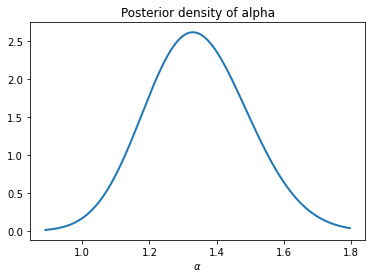

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of alpha')

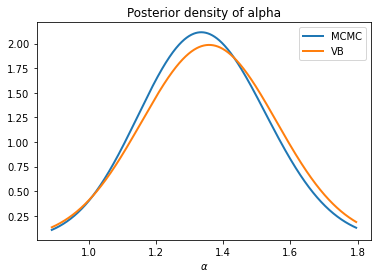

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.15, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

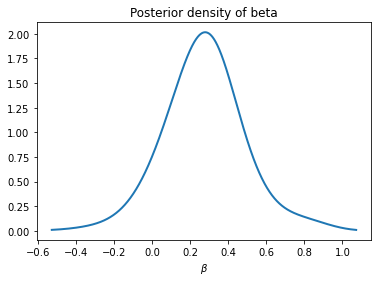

In [ ]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of beta')

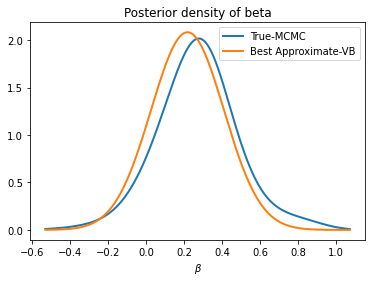

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.18, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'True-MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'Best Approximate-VB')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

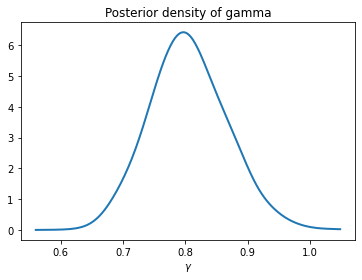

In [ ]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of gamma')

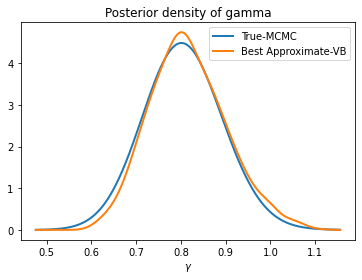

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.065, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.0225, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'True-MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'Best Approximate-VB')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

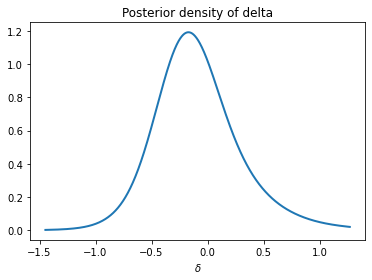

In [ ]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

Text(0.5, 1.0, 'Posterior density of delta')

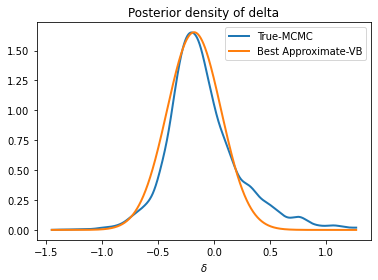

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.225, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'True-MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'Best Approximate-VB')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


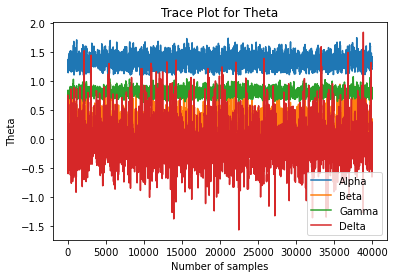

In [ ]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()